# CNN 기초

<img src = "https://drive.google.com/uc?id=1vl73MUOxobbZcqDf84vyeuUPAu--l2it" height = 200 width = 500>

- CNN(합성곱 신경망)은 이미지 인식 분야의 기초가 되는 신경망입니다.
- CNN은 합성곱 계층(Convolution layer), 풀링 계층(Pooling layer), 완전연결 계층(Fully-Connected layer) 세 개의 계층으로 이루어져 있습니다.

#### **Q1. 빈칸에 알맞은 계층의 이름을 넣어주세요.**

1. 심층신경망에서 다뤘던 완전연결 계층(Fully-Connected layer)은 '데이터의 형상을 무시한다'는 단점이 있습니다.
2. 반면에 합성곱 계층(Convolution layer)은 형상을 유지합니다. 3차원 데이터로 입력 받고, 3차원 데이터로 전달하기 때문에 이미지 데이터를 잘 처리할 수 있습니다.
3. 풀링 계층(Pooling layer)은 주로 합성곱 계층 다음에 위치하며, 가로•세로 방향의 공간을 줄이는 역할을 수행합니다.
4. 완전연결 계층(Fully-Connected layer)은 CNN의 마지막에서 각 레이어를 1차원으로 변환하여 분류를 결정합니다.

#### **Q2. 다음 빈칸을 채워주세요.**
- 합성곱 연산을 수행하기 전에 입력 데이터 주변을 0과 같은 특정 값으로 채우는 기법을 패딩(Padding)이라고 하고,
- 필터를 적용하는 위치의 간격을 스트라이드(Stride)라고 합니다.

# EMNIST dataset을 이용한 CNN 모델 실습

**Google Colab 사용 시 GPU 사용하기:**
- [런타임] - [런타임 유형 변경] - GPU에 연결 후 런타임 재시작한 후 실행하면 Google GPU를 사용하여 학습할 수 있습니다. 

필요한 라이브러리 불러오기

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchsummary

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

런타임 유형 확인하기
- Google GPU를 사용 중이면 'cuda', 그렇지 않으면 'cpu'를 출력합니다.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

device: cuda


#### (1) 데이터셋 불러오기, 데이터 전처리

**EMNIST Dataset from Torchvision**
- torchvision에서 제공하는 EMNIST 데이터셋은 알파벳과 숫자로 이루어진 데이터입니다.
- 이번 실습에서는 클래스별 데이터 수가 균형 있게 맞춰져있는 'balanced' 형태의 데이터셋을 이용하겠습니다.
- 총 47개의 클래스로 이루어져 있습니다. 대문자와 소문자 중 O, o와 같이 구분이 어려운 데이터를 제거하여 47개의 클래스만 존재합니다.

**47 LABELS**
- 숫자: '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
- 대문자: 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
- 소문자: 'a', 'b', 'd', 'e', 'f', 'g', 'h', 'n', 'q', 'r', 't'

<img src = "https://drive.google.com/uc?id=1tNMkoMnzMOsViOMHg8hslNgH4enV_2O-" height = 200 width = 500>

torchvision.datasets에서 EMNIST 데이터셋을 불러옵니다.

In [ ]:
train_data = torchvision.datasets.EMNIST(root = './data/EMNIST',
                                        split = 'balanced',
                                        train = True,
                                        download = True,
                                        transform = transforms.ToTensor())
test_data = torchvision.datasets.EMNIST(root = './data/EMNIST',
                                       split = 'balanced',
                                       train = False,
                                       download = True,
                                       transform = transforms.ToTensor())

train data를 train set과 validation set으로 나누겠습니다. validation set과 train set을 0.2:0.8로 나누어 주세요.

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_indices, val_indices, _, _ = train_test_split(range(len(train_data)),
                                                    train_data.targets,
                                                    stratify=train_data.targets,
                                                    test_size=0.2)

# generate subset based on indices
train_split = Subset(train_data, train_indices)
valid_split = Subset(train_data, val_indices)

train / validation / test set의 데이터 수를 확인합니다.

In [ ]:
len(train_split), len(valid_split), len(test_data)

(90240, 22560, 18800)

클래스 수, 채널 수와 하이퍼파라미터를 설정하겠습니다.
- EMNIST dataset(balanced)의 클래스 수는 47개입니다.
- 흑백 데이터이므로 입력 채널 수는 1입니다. rgb 컬러 데이터를 사용할 경우 입력 채널 수는 3입니다.

하이퍼파라미터는 다음과 같이 지정했습니다. 그러나 성능 개선을 하고 싶으신 경우, 임의로 바꾸셔도 무방합니다.
- batch size는 50으로 지정했습니다.
- learning rate는 0.001로 지정했습니다.
- epoch의 수는 6으로 지정했습니다.

In [ ]:
# Adjust Dataset classes and channels
num_classes = 47
in_channel = 1

# Hyper-parameters
batch_size = 50
learning_rate = 0.001
num_epochs = 6

이제 데이터로더의 형태로 변환해주겠습니다.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_split, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_split, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

데이터셋의 이미지 중 8개만 시각화해서 확인해보겠습니다.

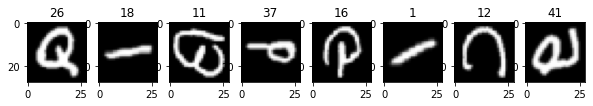

In [ ]:
def image_show(dataset, num):
  fig = plt.figure(figsize=(10,10))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i+1200][0].squeeze(), cmap = "gray")
    plt.title(dataset[i+1200][1])

image_show(train_data, 8)

#### (2) CNN 모델 구성하기

3개의 컨볼루션 층과 2개의 완전연결 층으로 구성된 CNN 모델을 만들겠습니다.
1. layer1 (Convolution + Pooling)
2. layer2 (Convolution + Pooling)
3. layer3 (Convolution + Pooling)
4. fc1 (Fully-Connected)
5. fc2 (Fully-Connected)

각 레이어마다 출력 사이즈를 확인하며 빈칸을 채워주세요.

<img src = "https://drive.google.com/uc?id=1gXaXy3vs_8N35vKIkT0VPxoeHa40xrVW" height = 300 width = 400>

[참고1] Convolution layer에서 width, height 계산하기
- 출력 width = (입력 width + 2*padding - filter)/stride + 1
- 출력 height = (입력 height + 2*padding - filter)/stride + 1
- CNN에서 필터(filter)와 커널(kernel)은 같은 개념입니다.

[참고2] Pooling layer의 output size = input size/pooling size

<img src = "https://drive.google.com/uc?id=19D63sCenWQIM_IEFWKArLlhNNkOuJumE" height = 350 width = 350>

In [ ]:
class CNN(nn.Module):
  def __init__(self, num_classes=47):
    super(CNN, self).__init__()

    #input size: 1x28x28
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=in_channel, out_channels=10, kernel_size=5, stride=1, padding=2),  #10x28x28, 채널 수 입력 1 -> 출력 10, 가로 세로 입력 28 -> 출력 (28+2*2-5)/1+1 = 28 
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  #10x14x14, pooling 시 채널 수에는 변화 없음. 가로 세로 입력 28 -> 출력 28/2 = 14
        nn.Dropout()
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=25, kernel_size=5, stride=1, padding=1), #25x12x12가 되도록 빈칸(out_channels) 채우기
        nn.BatchNorm2d(25),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),  #25x6x6이 되도록 kernel size 지정하기
        nn.Dropout()
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=25, out_channels=45, kernel_size=5, stride=1, padding=2),  #45x6x6가 되도록 빈칸(padding) 채우기
        nn.BatchNorm2d(45),
        nn.ReLU(),
        nn.Dropout()
    )


    self.fc1 = nn.Linear(45*6*6, 600)   #fc1의 입력값 = layer3의 출력값(45*6*6=1620)
    self.fc2 = nn.Linear(600, 47)   #fc2의 출력값 = EMNIST dataset의 클래스 수 (47)

    #initialization
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data)
        nn.init.normal_(m.bias.data)


  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.reshape(x.size(0), -1)   #3차원 데이터셋을 완전연결층에 넣기 위해 1차원 데이터 형태로 바꿔줌.
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    
    return x

모델 생성

In [ ]:
model = CNN(47).to(device)

CNN 모델의 shape 변화 확인하기

In [ ]:
torchsummary.summary(model, input_size=(1, 28, 28), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]             260
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
         MaxPool2d-4           [-1, 10, 14, 14]               0
           Dropout-5           [-1, 10, 14, 14]               0
            Conv2d-6           [-1, 25, 12, 12]           6,275
       BatchNorm2d-7           [-1, 25, 12, 12]              50
              ReLU-8           [-1, 25, 12, 12]               0
         MaxPool2d-9             [-1, 25, 6, 6]               0
          Dropout-10             [-1, 25, 6, 6]               0
           Conv2d-11             [-1, 45, 6, 6]          28,170
      BatchNorm2d-12             [-1, 45, 6, 6]              90
             ReLU-13             [-1, 45, 6, 6]               0
          Dropout-14             [-1, 4

#### (3) 모델 학습 및 평가

손실 함수, 옵티마이저 지정하기
- 손실함수는 크로스엔트로피 (nn.CrossEntropyLoss()) 사용
- 옵티마이저는 Adam 옵티마이저 사용

스케줄러 지정하기
- MultiplicativeLR 스케줄러 사용. 이전 epoch의 learning rate에 0.97을 곱한 값이 다음 epoch의 learning rate가 되도록 적용.

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer,
                                                lr_lambda=lambda epoch: 0.97 ** epoch)

학습 실행 (Google Colab GPU 기준 3분 이내로 실행.)


In [ ]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
  
  # Train  
  model.train()
  TL=0
  TA=0
  for i, (images, labels) in enumerate(train_loader):
    # Assign Tensors to Configured Device
    images = images.to(device)
    labels = labels.to(device)
    # Forward Propagation
    outputs = model(images)
    # Get Loss, Compute Gradient, Update Parameters
    t_loss = criterion(outputs, labels) 
    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()
    # Append loss and accuracy
    TL += t_loss.item()
    t_acc = 0
    _, pred = torch.max(outputs.data, 1)
    t_acc += (pred == labels).sum().item()
    TA += t_acc

  # Validation
  model.eval()
  VL = 0
  VA = 0
  with torch.no_grad():
    for i, (images, labels) in enumerate(valid_loader):
      # Assign Tensors to Configured Device
      images = images.to(device)
      labels = labels.to(device)
      # Forward Propagation
      outputs = model(images)
      # Get and Append Loss
      v_loss = criterion(outputs, labels)
      VL += v_loss.item()
      # Append accuracy
      v_acc = 0
      _, pred = torch.max(outputs.data, 1)
      v_acc += (pred == labels).sum().item()
      VA += v_acc

  print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {TL/len(train_loader):.4f}, Train Acc: {TA/len(train_split)*100:.2f}%, Valid Loss: {VL/len(valid_loader):.4f}, Valid Acc: {VA/len(valid_split)*100:.2f}%')
  train_loss_list.append(TL/len(train_loader))
  train_acc_list.append(TA/len(train_split)*100)
  val_loss_list.append(VL/len(valid_loader))
  val_acc_list.append(VA/len(valid_split)*100)

  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), 'model.pth')
    torch.load("model.pth")
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

Epoch [1/6], Train Loss: 0.4798, Train Acc: 82.88%, Valid Loss: 0.3797, Valid Acc: 86.33%
Epoch [2/6], Train Loss: 0.4646, Train Acc: 83.36%, Valid Loss: 0.3693, Valid Acc: 86.71%
Epoch [3/6], Train Loss: 0.4503, Train Acc: 83.79%, Valid Loss: 0.3673, Valid Acc: 86.89%
Epoch [4/6], Train Loss: 0.4410, Train Acc: 84.13%, Valid Loss: 0.3625, Valid Acc: 86.87%
Epoch [5/6], Train Loss: 0.4338, Train Acc: 84.21%, Valid Loss: 0.3513, Valid Acc: 87.33%
Epoch [6/6], Train Loss: 0.4225, Train Acc: 84.66%, Valid Loss: 0.3516, Valid Acc: 87.17%


Loss와 Accuracy 시각화하기

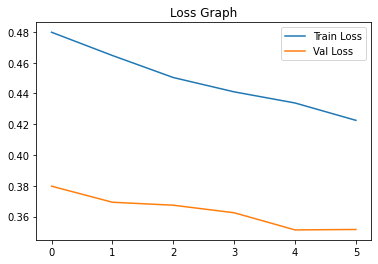

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label="Train Loss")
plt.plot(val_loss_list, label="Val Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()

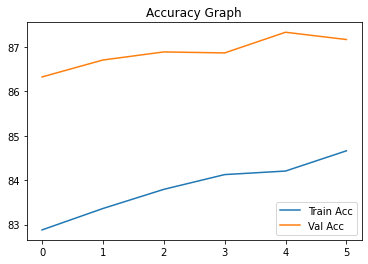

In [ ]:
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.legend()
plt.title("Accuracy Graph")
plt.show()

실행 결과, epoch 5에 비해 epoch 6에서 training loss, training accuracy는 모두 조금씩 좋아졌지만, validation loss, validation accuracy는 epoch 5에서 더 성능이 좋게 나타났습니다. 따라서 epoch 5의 모델을 사용하여 test를 진행했습니다.

그러나 실행마다 결과가 다르게 나타날 수 있으므로, 본인의 실행 결과를 보시고 적절한 모델을 선정해주시면 되겠습니다.

In [ ]:
test_model = CNN(47).to(device)
test_model.load_state_dict(torch.load("model.pth"))   #학습 완료 후 모델 선택하기
#test_model.load_state_dict(torch.load("model-05_epochs.pth"))  5번 epoch 모델 선택하기

<All keys matched successfully>

테스트를 진행하겠습니다.

In [ ]:
test_model.eval()

with torch.no_grad():
  correct = 0
  
  for img, lab in test_loader:
    img = img.to(device)
    lab = lab.to(device)
    out = test_model(img)
    _, pred = torch.max(out.data, 1)
    correct += (pred == lab).sum().item()

  print("Accuracy of the network on the {} test images: {}%".format(len(test_loader)*batch_size, 100 * correct / (len(test_loader) * batch_size)))

Accuracy of the network on the 18800 test images: 86.83510638297872%


제 모델은 테스트 데이터셋에 대해 86.84%의 정확도를 보였습니다.

실습을 위해 단순한 모델을 사용했지만, layer 구조 변화, 하이퍼파라미터 조정 등을 통해 EMNIST 분류 모델의 성능을 95% 이상까지 충분히 올릴 수 있습니다. CNN과 이미지 처리에 관심 있는 분들께서는 모델과 학습 방법을 변형하여 더 좋은 모델을 만들어보는 것을 추천드립니다.

# 전이학습 (Pretrained model 이용)

- 이번에는 torchvision.models에 있는 AlexNet, VGG16, ResNet을 이용해보도록 하겠습니다.
- torchvision.models의 모델들은 pretrained된 형태로 불러오는 방법과, 그렇지 않고 모델 구조만 불러오는 방법이 있습니다.
- 오늘은 그중 pretrained된 모델을 이용하여 이미지 데이터에 대한 분류 성능을 확인해보겠습니다.
- OpenCV에서 운영하는 learnopencv 사이트의 pretrained model의 image classification을 참고했습니다. 코드 이해 및 작성에 어려움이 있으신 분들께서는 다음의 사이트를 참고하시면 좋습니다.
https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models

#### (1) torchvision의 pretrained model 불러오기

torchvision.models 라이브러리에 포함되어 있는 모델 목록 확인하기

In [ ]:
from torchvision import models

In [ ]:
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

alexnet, resnet, vggnet을 pretrained된 형태로 불러온 후, 평가 모드로 지정하겠습니다.

torchvision의 models 라이브러리에서 alexnet, resnet101, vgg16 모델을 불러와주세요. pretrained 속성을 True로 지정해야 학습된 모델을 불러올 수 있습니다.

In [ ]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval()

resnet = models.resnet101(pretrained=True)
resnet.eval()

vggnet = models.vgg16(pretrained=True)
vggnet.eval()

#### (2) 학습에 필요한 준비하기
- 이미지 준비하기
- 이미지 전처리
- class 목록 불러오기

alexnet, vgg16, resnet은 입력 형태가 고정되어 있습니다. 따라서 우리가 입력할 이미지를 각 모델들이 잘 읽을 수 있는 형태로 모양을 바꿔주는 transform 함수가 필요합니다.

**transform 과정**
1. 사이즈를 256x256으로 변환해줍니다. transform의 Resize 함수를 이용해주세요.
2. 256x256 크기의 이미지의 중심을 224x224 크기로 잘라줍니다. transform의 CenterCrop 함수를 이용해주세요.
3. pytorch tensor 형태로 변환해줍니다.
4. 이미지를 정규화해줍니다. mean(평균)은 [0.485, 0.456, 0.406]으로, std(표준편차)는 [0.229, 0.224, 0.225]로 지정해줍니다. transform의 Normalize 함수를 이용해주세요.

In [ ]:
from torchvision import transforms
transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

세 모델은 ImageNet의 class와 동일한 1000개의 class를 사용하여 이미지를 분류합니다. 다음 github 링크에서 Imagenet_classes.txt 파일을 읽어오겠습니다.

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

# Read the categories
with open('imagenet_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]

--2023-03-17 12:39:45--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-03-17 12:39:45 (106 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



<img src = "https://drive.google.com/uc?id=1PBHtwZQ6DjK3FX8F0GZCWqSJXS3WR7LM" height = 250 width = 300>
<img src = "https://drive.google.com/uc?id=1U1uAi1aqqAvyyT5DXIQJEsYk-Q_1Ux7d" height = 250 width = 300>

dog.jpg / wallet.jpg

오늘 사용할 강아지(Labrador retriever)와 지갑(wallet) 이미지입니다. 두 파일을 불러와주세요.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
from PIL import Image
img_dog = Image.open("dog.jpg")
img_wal = Image.open("wallet.jpg")

위에서 정의한 transform 함수를 이용하여 이미지를 전처리한 후, unsqueeze 함수를 이용하여 입력 차원에 맞는 형태로 변환하겠습니다.

output img = transform(input img) 형태로 코드를 작성해주세요.

In [ ]:
img1_t = transform(img_dog)
batch1_t = torch.unsqueeze(img1_t, 0)

img2_t = transform(img_wal)
batch2_t = torch.unsqueeze(img2_t, 0)

alexnet, vggnet, resnet에 전처리한 이미지를 각각 넣어줍니다.

In [ ]:
out1_alex = alexnet(batch1_t)
out2_alex = alexnet(batch2_t)
out1_vgg = vggnet(batch1_t)
out2_vgg = vggnet(batch2_t)
out1_res = resnet(batch1_t)
out2_res = resnet(batch2_t)

#### (3) 분류 결과

먼저 강아지 이미지의 분류 결과입니다.

In [ ]:
percentage1_alex = torch.nn.functional.softmax(out1_alex, dim=1)[0] * 100
percentage1_vgg = torch.nn.functional.softmax(out1_vgg, dim=1)[0] * 100
percentage1_res = torch.nn.functional.softmax(out1_res, dim=1)[0] * 100

names = ['AlexNet', 'VGGNet', 'ResNet']
per1s = [percentage1_alex, percentage1_vgg, percentage1_res]

for i in range(len(names)):
  print(f'---Top 5 Classification Result of Dog Image with {names[i]}---')
  top5_prob, top5_catid = torch.topk(per1s[i], 5)
  for j in range(top5_prob.size(0)):
    print(classes[top5_catid[j]], top5_prob[j].item())
  print()

---Top 5 Classification Result of Dog Image with AlexNet---
Labrador retriever 41.585166931152344
golden retriever 16.59166145324707
Saluki 16.286865234375
whippet 2.853907823562622
Ibizan hound 2.392474412918091

---Top 5 Classification Result of Dog Image with VGGNet---
Labrador retriever 58.63425827026367
golden retriever 6.773653507232666
kelpie 3.932812452316284
dingo 3.213341236114502
Chesapeake Bay retriever 2.846713066101074

---Top 5 Classification Result of Dog Image with ResNet---
Labrador retriever 48.25550079345703
dingo 7.900805950164795
golden retriever 6.916906833648682
Eskimo dog 3.6434433460235596
bull mastiff 3.0461323261260986



##### **Q24. 분류 결과를 간단하게 서술해주세요. 어떤 모델이 가장 성능이 좋은가요?**
- 세 모델 모두 top1에서 정답(Labrador retriever)을 맞혔습니다. 정답의 확률은 VGGNet(59%), ResNet(48%), AlexNet(42%) 순으로 높습니다.

지갑 이미지의 분류 결과입니다.

In [ ]:
percentage2_alex = torch.nn.functional.softmax(out2_alex, dim=1)[0] * 100
percentage2_vgg = torch.nn.functional.softmax(out2_vgg, dim=1)[0] * 100
percentage2_res = torch.nn.functional.softmax(out2_res, dim=1)[0] * 100

names = ['AlexNet', 'VGGNet', 'ResNet']
per2s = [percentage2_alex, percentage2_vgg, percentage2_res]

for i in range(len(names)):
  print(f'---Top 5 Classification Result of Wallet Image with {names[i]}---')
  top5_prob, top5_catid = torch.topk(per2s[i], 5)
  for j in range(top5_prob.size(0)):
    print(classes[top5_catid[j]], top5_prob[j].item())
  print()

---Top 5 Classification Result of Wallet Image with AlexNet---
grand piano 27.07549285888672
iPod 15.27747631072998
racket 11.05449390411377
harmonica 3.0107903480529785
pencil box 2.9472732543945312

---Top 5 Classification Result of Wallet Image with VGGNet---
wallet 54.908050537109375
purse 22.11951446533203
holster 7.969642639160156
Loafer 5.719700336456299
buckle 3.6906771659851074

---Top 5 Classification Result of Wallet Image with ResNet---
wallet 88.03205108642578
purse 11.857146263122559
binder 0.037626318633556366
book jacket 0.028713451698422432
pencil box 0.013752278871834278



##### **Q25. 분류 결과를 간단하게 서술해주세요. 어떤 모델이 가장 성능이 좋은가요?**
- VGGNet과 ResNet은 top1에서 정답을 맞혔고, ResNet은 88%, VGGNet은 55%로 정답의 확률을 예측했습니다. AlexNet은 top5 안에서 정답을 예측하지 못했습니다.

[참고] 이미지 데이터마다 분류를 잘하는 모델이 다를 수 있지만, 대체로 ResNet > VGG16 > AlexNet 순으로 분류 정확도가 높다고 알려져 있습니다.

torchvision의 pretrained image model들로 정확도 테스트를 한 결과, Top-1 error (1위로 추측한 클래스가 정답이 아닌 경우), Top-5 error(1위~5위로 추측한 클래스 중에 정답이 없는 경우)가 다음과 같은 결과를 얻었습니다.

<img src = "https://drive.google.com/uc?id=1EVoX7Fjd4_Drj-9a9eyqHi-RgFSVB5ed" height = 300 width = 500>


감사합니다.